In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

df = pd.read_csv("ALLTEAMSQvFDetail2016.csv")

In [2]:
df['gridPos'] = pd.to_numeric(df['gridPos'], errors='coerce')
df = df.dropna(subset=['gridPos'])

In [3]:
df['raceResult'] = pd.to_numeric(df['raceResult'], errors='coerce')

In [4]:
pairs = pd.merge(
    df, df,
    on=['Year', 'Team', 'raceName'],
    suffixes=('', '_tm')
)
pairs = pairs[pairs['Driver'] != pairs['Driver_tm']]
pairs = pairs[pairs['driverNum'] < pairs['driverNum_tm']]


In [5]:
pairs['Qualified Ahead']   = (pairs['gridPos'] < pairs['gridPos_tm']).astype(int)
pairs['Grid Difference']   = (pairs['gridPos_tm'] - pairs['gridPos']).abs()

In [6]:
FILL = 999 

race_driver = pairs['raceResult'].fillna(FILL)
race_tm     = pairs['raceResult_tm'].fillna(FILL)

pairs['Finished Ahead'] = np.where(
    race_driver < race_tm, 1,
    np.where(race_driver > race_tm, 0, np.nan)
)
pairs['Race Result Difference'] = (race_driver - race_tm).abs()


In [7]:
forward = pairs[[
    'Driver', 'Driver_tm', 'Team', 'Year', 'raceName',
    'Qualified Ahead', 'Grid Difference',
    'Finished Ahead', 'Race Result Difference'
]].rename(columns={
    'Driver_tm': 'Teammate',
    'raceName':  'Race'
})

reverse = forward.copy()

reverse['Qualified Ahead'] = forward['Qualified Ahead'].map(lambda x: 1 - x)
reverse['Finished Ahead']   = forward['Finished Ahead'].map(
    lambda x: 1 - x if pd.notna(x) else np.nan
)

reverse.rename(columns={'Driver':'Teammate','Teammate':'Driver'}, inplace=True)

In [8]:
comparison_df = pd.concat([forward, reverse], ignore_index=True)

print(comparison_df.head(10))


            Driver      Teammate                       Team  Year  \
0  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
1  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
2  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
3  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
4  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
5  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
6  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
7  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
8  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   
9  Alexander Albon  Daniil Kvyat  Red Bull Toro Rosso Honda  2019   

                    Race  Qualified Ahead  Grid Difference  Finished Ahead  \
0  Australian Grand Prix                1                2             0.0   
1     Bahrain Grand Prix                1                3             1.0   
2     

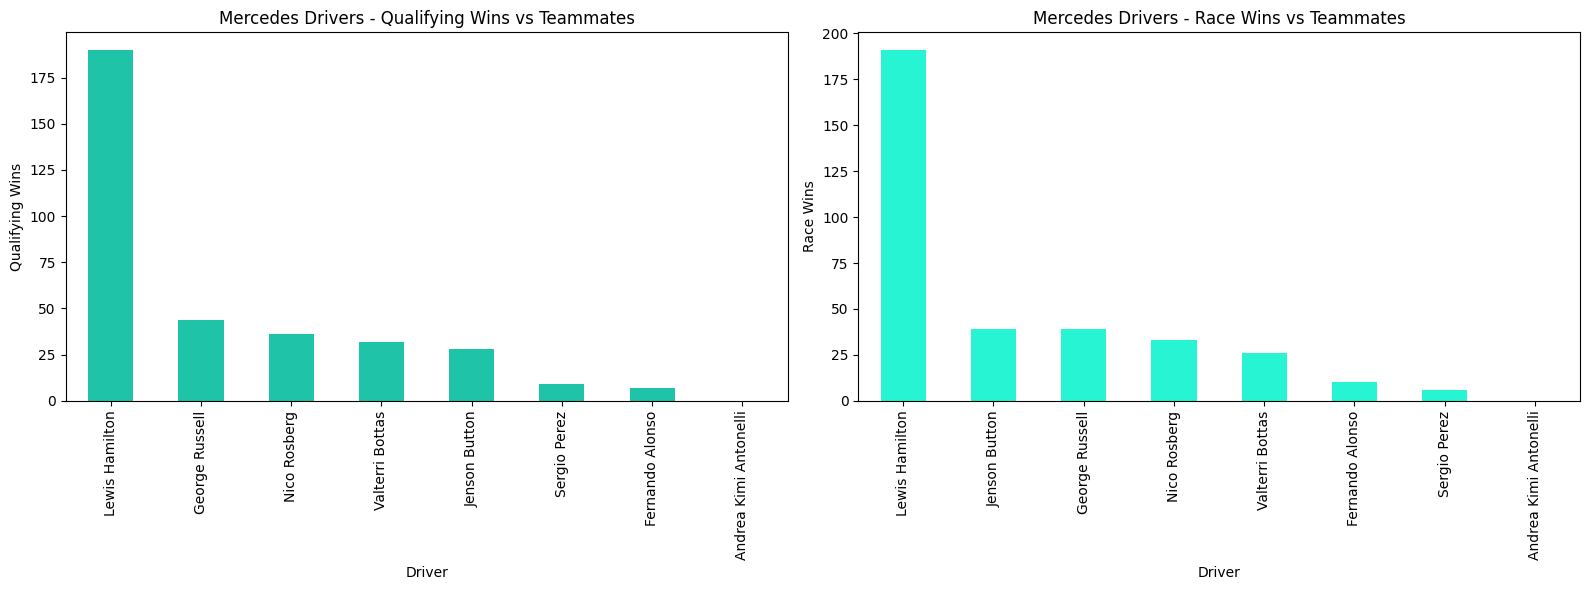

In [20]:
finished_df = comparison_df[comparison_df['Finished Ahead'].notna()]

TEAM = 'Mercedes'

rb_qual = comparison_df.loc[
    comparison_df['Team'].str.contains(TEAM, case=False, na=False),
    ['Driver','Qualified Ahead']
]

rb_race = finished_df.loc[
    finished_df['Team'].str.contains(TEAM, case=False, na=False),
    ['Driver','Finished Ahead']
]

qual_wins = rb_qual.groupby('Driver')['Qualified Ahead'] \
                   .sum() \
                   .sort_values(ascending=False)

race_wins = rb_race.groupby('Driver')['Finished Ahead'] \
                   .sum() \
                   .sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

qual_wins.head(10).plot(
    kind='bar', ax=ax[0],
    color='#1fc3a8',
    title='Mercedes Drivers - Qualifying Wins vs Teammates'
)
ax[0].set_ylabel('Qualifying Wins')

race_wins.head(10).plot(
    kind='bar', ax=ax[1],
    color='#27F4D2',
    title='Mercedes Drivers - Race Wins vs Teammates'
)
ax[1].set_ylabel('Race Wins')

plt.tight_layout()
plt.show()


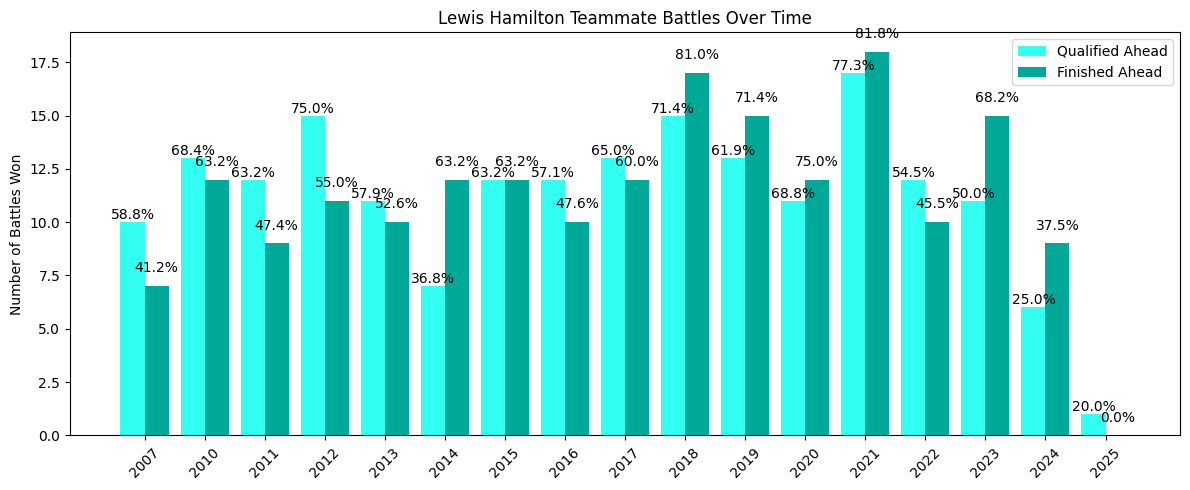

In [21]:
plt.style.use('default')  


team_colors = {
    'Red Bull': '#1E41FF',
    'Mercedes':       '#00D2BE',
    'Ferrari':        '#ef1a2d',
    'McLaren':        '#FF8700',
    'Aston Martin':   '#006F62',
    'Alpine':         '#0090FF',
    'Williams':       '#005AFF',
    'AlphaTauri':     '#2B4562',
    'Haas F1 Team':   '#B6BABD',
    'Alfa Romeo':     '#900000'
}

driver_focus = 'Lewis Hamilton'
team_keyword = 'Mercedes'

mask = (
    (comparison_df['Driver'] == driver_focus)
    & comparison_df['Team']
        .str.contains(team_keyword, case=False, na=False)
    
    & comparison_df['Team']
        .str.contains(team_keyword, case=False, na=False)
)

driver_battles = comparison_df.loc[mask]

summary = driver_battles.groupby('Year')[['Qualified Ahead', 'Finished Ahead']].sum()
totals  = driver_battles.groupby('Year')['Finished Ahead'].count() 
base_color = team_colors.get(team_keyword, '#888888')
base_rgb   = mcolors.to_rgb(base_color)
qual_color = mcolors.to_hex([min(c + 0.2, 1.0) for c in base_rgb])
race_color = mcolors.to_hex([c * 0.8 for c in base_rgb])
driver_battles = comparison_df[comparison_df['Driver'] == driver_focus]
summary = driver_battles.groupby('Year')[['Qualified Ahead', 'Finished Ahead']].sum()
totals = driver_battles.groupby('Year').size()
pct_qual   = summary['Qualified Ahead'] / totals * 100
pct_finish = summary['Finished Ahead'] / totals * 100
years     = summary.index.astype(str)
qualified = summary['Qualified Ahead'].values
finished  = summary['Finished Ahead'].values
x         = range(len(years))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x,
               qualified,
               width=bar_width,
               label='Qualified Ahead',
               color=qual_color)
bars2 = ax.bar([i + bar_width for i in x],
               finished,
               width=bar_width,
               label='Finished Ahead',
               color=race_color)
for bar, pct in zip(bars1, pct_qual):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,  
        h + 0.00,                          
        f'{pct:.1f}%',                  
        ha='center',
        va='bottom'
    )

for bar, pct in zip(bars2, pct_finish):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.5,
        f'{pct:.1f}%',
        ha='center',
        va='bottom'
    )

ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(years, rotation=45)
ax.set_ylabel('Number of Battles Won')
ax.set_title(f'{driver_focus} Teammate Battles Over Time')
ax.legend()
plt.tight_layout()
plt.show()


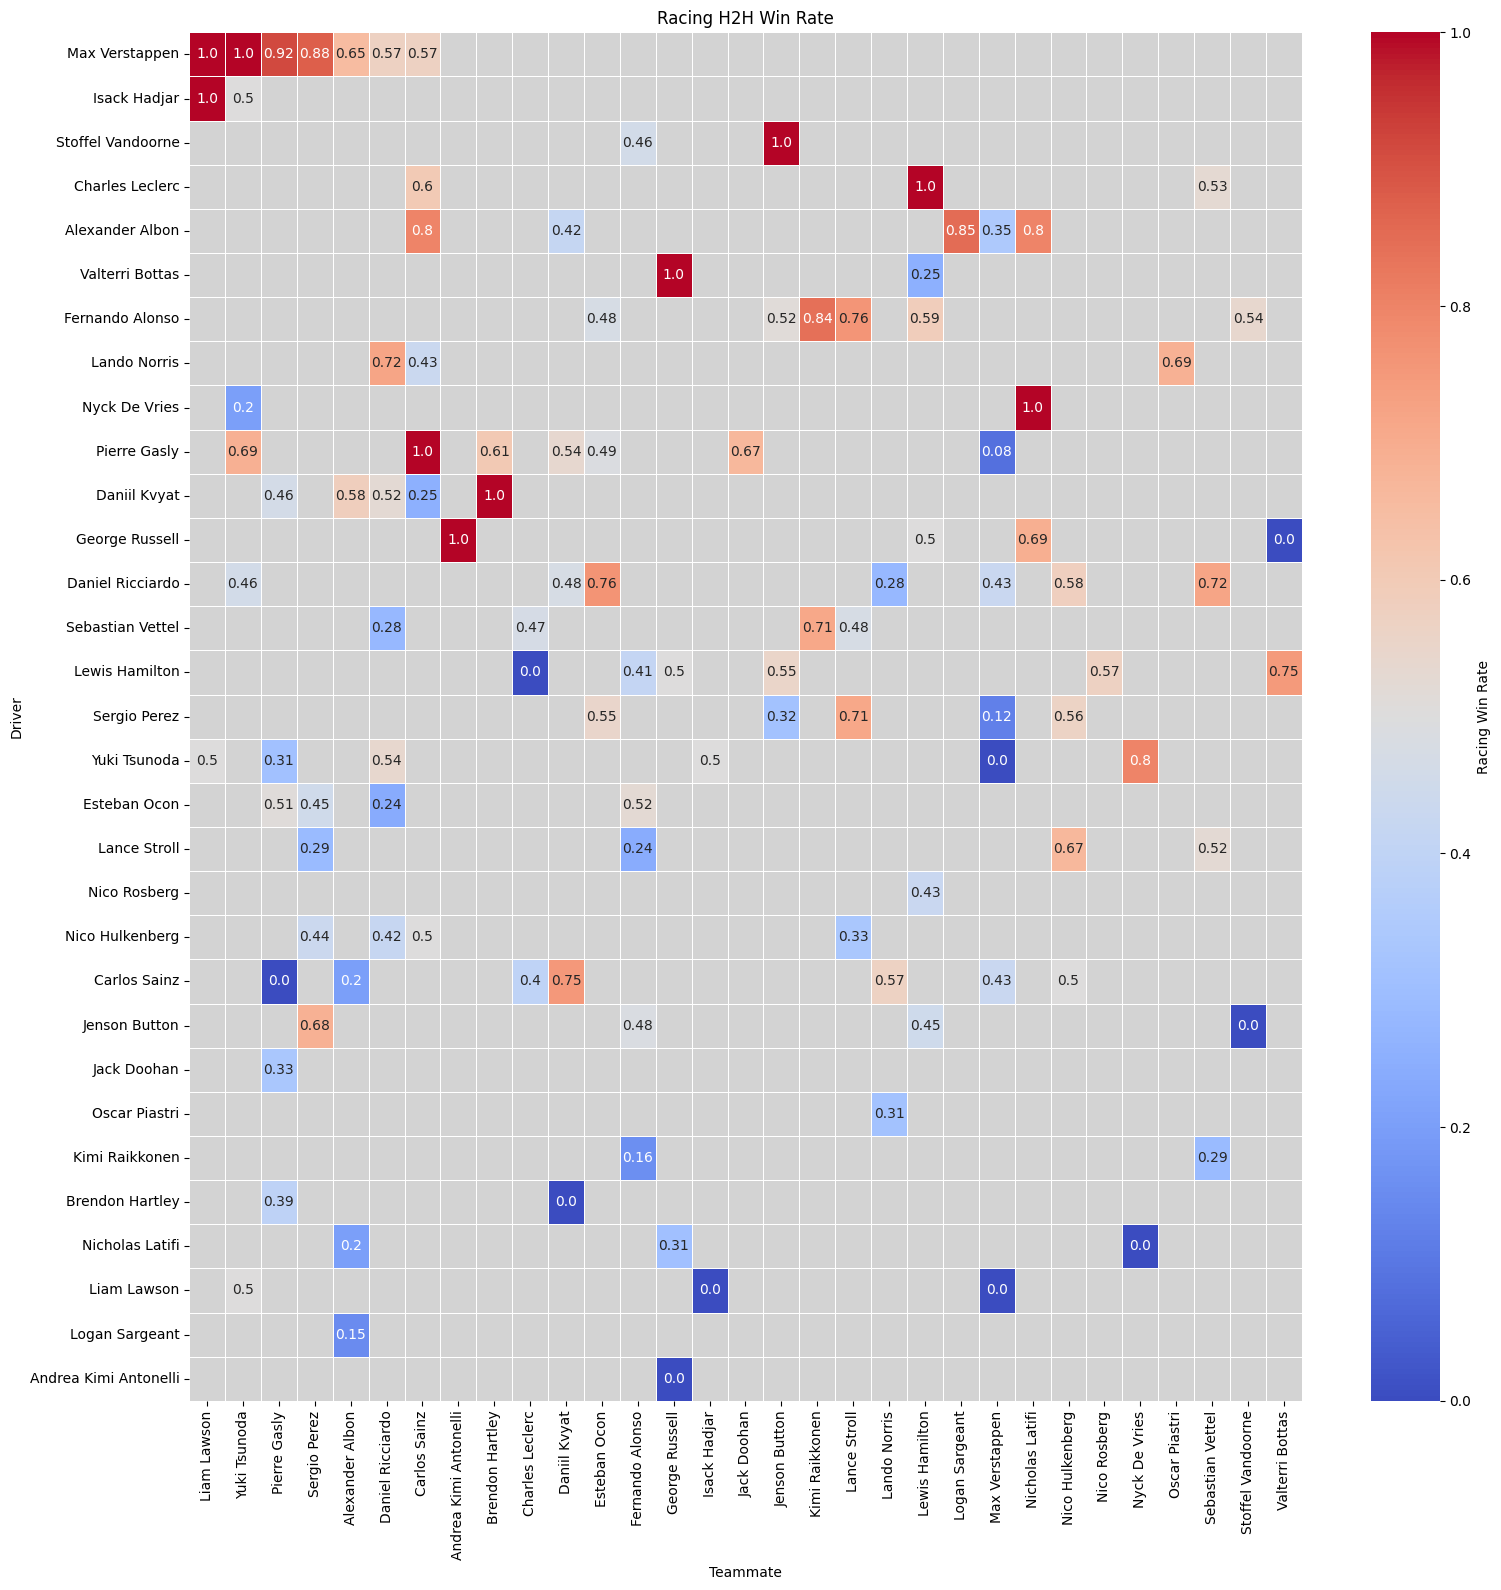

In [15]:

win_rate = comparison_df.groupby(['Driver','Teammate'])['Finished Ahead'] \
                        .mean().unstack().fillna(0)

counts   = comparison_df.groupby(['Driver','Teammate']).size() \
                        .unstack().fillna(0)
masked = win_rate.copy()
masked[counts == 0] = np.nan
row_order = masked.mean(axis=1).sort_values(ascending=False).index
top_driver = row_order[0]
col_order = masked.loc[top_driver].sort_values(ascending=False).index

masked = masked.loc[row_order, col_order]
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='lightgray')
annot = masked.round(2).fillna('')

plt.figure(figsize=(16,16))
sns.heatmap(
    masked,
    annot=annot,
    fmt='',
    cmap=cmap,
    linewidths=0.5,
    cbar_kws={'label':'Racing Win Rate'}
)
plt.title("Racing H2H Win Rate")
plt.ylabel("Driver")
plt.xlabel(f"Teammate")
plt.tight_layout()
plt.show()


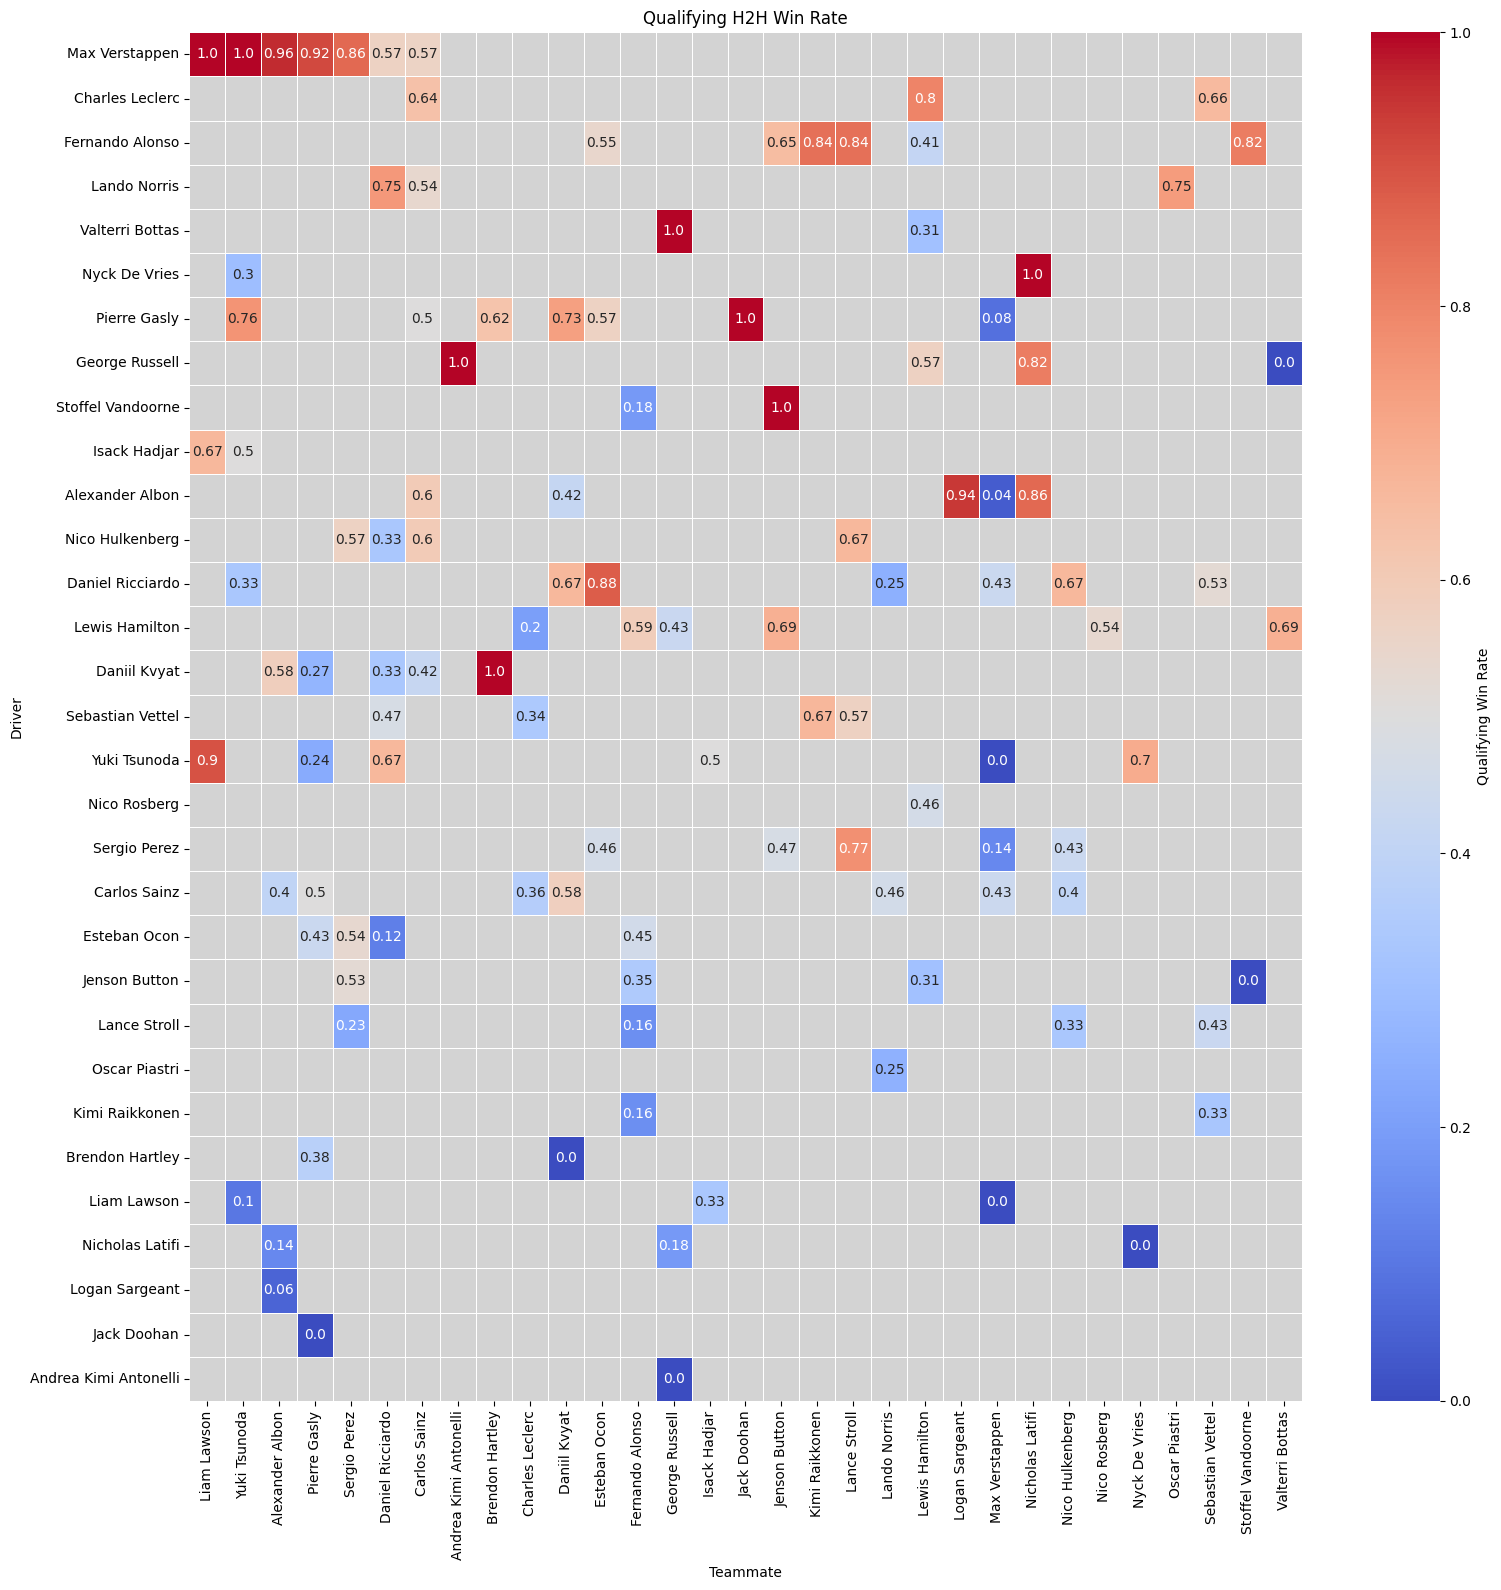

In [16]:

win_rate = comparison_df.groupby(['Driver','Teammate'])['Qualified Ahead'] \
                        .mean().unstack().fillna(0)

counts   = comparison_df.groupby(['Driver','Teammate']).size() \
                        .unstack().fillna(0)
masked = win_rate.copy()
masked[counts == 0] = np.nan
row_order = masked.mean(axis=1).sort_values(ascending=False).index
top_driver = row_order[0]
col_order = masked.loc[top_driver].sort_values(ascending=False).index

masked = masked.loc[row_order, col_order]
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='lightgray')
annot = masked.round(2).fillna('')

plt.figure(figsize=(16,16))
sns.heatmap(
    masked,
    annot=annot,
    fmt='',
    cmap=cmap,
    linewidths=0.5,
    cbar_kws={'label':'Qualifying Win Rate'}
)
plt.title("Qualifying H2H Win Rate")
plt.ylabel("Driver")
plt.xlabel(f"Teammate")
plt.tight_layout()
plt.show()
